## Read dataset and create a graph

In [1]:
import re
import random
import pandas as pd
import numpy as np
import networkx as nx
from itertools import count
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

In [2]:
version = '0.1.3'
file_name = 'novels_' + version + '.csv'

In [202]:
df = pd.read_csv(file_name, na_values='NaN')
G = nx.Graph()

# Add nodes
def get_node_label(genres):
    return {'genre': random.choice(genres)}

df['genres'] = df['genres'].str.replace("['\[\]]", '', regex=True).str.split(", ")

nodes = [(t[0], get_node_label(t[1])) for t in df[['id', 'genres']].values]
G.add_nodes_from(nodes)

# Add edges
edge_attr = 'recommended_series_ids'
df_edge = df.loc[~df[edge_attr].isnull()].copy()
df_edge[edge_attr] = df_edge.loc[:, edge_attr].str.strip('[]').str.split(',')

edges = []
for source_node, node_edges in df_edge[['id', edge_attr]].values:
    for target_node in node_edges:
        if int(target_node) in G.nodes():
            edges.append((source_node, int(target_node)))
G.add_edges_from(edges)

print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 13582
Number of edges: 33798


In [203]:
# Remove nodes in small clusters
remove = [n for c in nx.connected_components(G) for n in c if len(c) < 10]
G.remove_nodes_from(remove)

# Select a random sample of nodes
start_node = random.choice(list(G.nodes()))
nodes = nx.bfs_tree(G, start_node, reverse=False, depth_limit=3, sort_neighbors=None).nodes()
G.remove_nodes_from(G.nodes() - nodes)

print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 291
Number of edges: 740


In [204]:
# Get color dictionary
genres = df['genres'].explode().unique()
mapping = dict(zip(sorted(genres), count()))
colors = [mapping[G.nodes[n]['genre']] for n in G.nodes()]

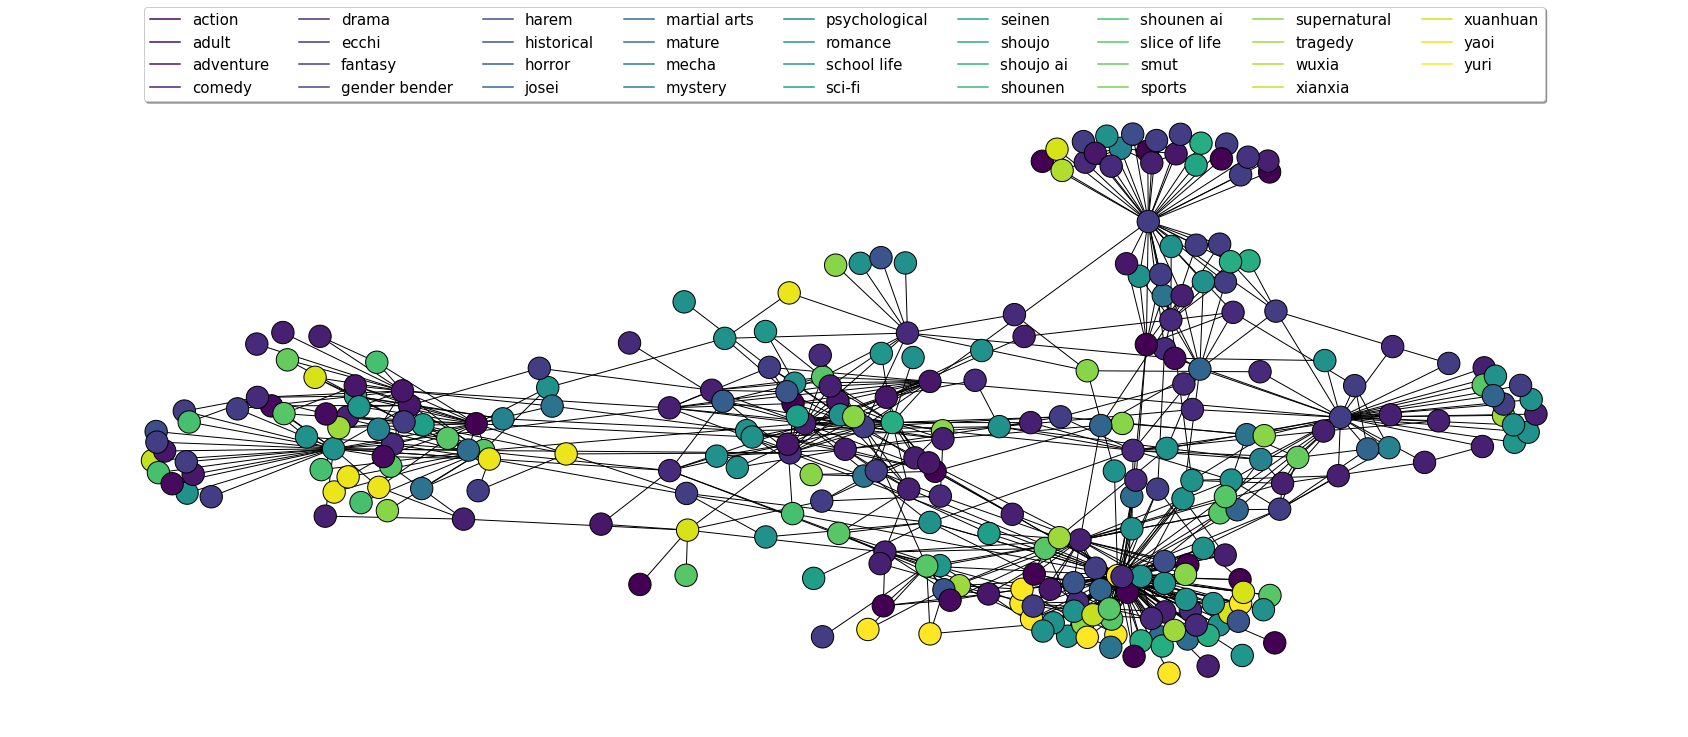

In [228]:
fig = plt.figure(figsize=(30, 12)) 
ax = fig.add_subplot(1,1,1)

# Colors and legend inforamtion
cmap = plt.cm.viridis
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=max(mapping.values()))
sm = ScalarMappable(cnorm, cmap)
for label in mapping:
    ax.plot([0],[0], color=sm.to_rgba(mapping[label]),label=label)

# Draw
nx.draw_spring(G, node_color=colors, node_size=500, with_labels=False, cmap=plt.cm.viridis, edgecolors='black', ax=ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=9, fancybox=True, shadow=True, fontsize=15)
plt.show() 
fig.savefig('graph.svg') 